<a href="https://colab.research.google.com/github/bethanystate/ISyE6202/blob/main/Casework_2_All_Tasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Excel Data

In [23]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1mWtI5rM6q3mND741ytjbi-rXiTcNaznH'
downloaded = drive.CreateFile({'id': file_id})

In [24]:
downloaded.GetContentFile('GivenData.xlsx')

In [25]:
!ls -lha GivenData.xlsx

-rw-r--r-- 1 root root 26K Oct 22 23:53 GivenData.xlsx


In [26]:
!pip install -q xlrd

import pandas as pd
from openpyxl import load_workbook

df = pd.read_excel('GivenData.xlsx')

# Task 1 - Simulator

Demand Based on Year, Period, and Day


In [27]:
import random
from numpy.random import choice
import itertools
import numpy as np

demand_table = pd.read_excel('GivenData.xlsx', 'Demand Forecast', usecols=range(1,7), skiprows=range(6,9,1))
sim_demand = demand_table.sample(n=1, weights='Probability') #Random yearly demand based on probability

period = pd.read_excel('GivenData.xlsx', 'Transpose', usecols=range(4,6), skiprows=range(14,20,1))
sim_period = period.sample(n=1) #Random 4-week period

day_of_week = pd.read_excel('GivenData.xlsx', 'Transpose', usecols=range(8,10), skiprows=range(8,20,1))
period_demand = sim_demand.mul(other=sim_period.iloc[0]['Demand share']) #Demand within a given period

space_table = pd.read_excel('GivenData.xlsx', 'Transpose', usecols=range(1,3), skiprows=range(19,20,1))
sim_space = space_table.sample(n=1, weights='Probability') #Random locker based on weights

In [28]:
print('The simulated yearly demand forcast is')
print(sim_demand)

print('The simulated 4-week period and Demand share is')
print(sim_period)

print('The simulated yearly demand based on given period is')
print(period_demand[['Year 1','Year 2','Year 3','Year 4', 'Year 5']])

print('The simulated daily demand for a given period and year is')
#Daily demand on a given days within a given period
daily_demand = pd.concat([period_demand.mul(other = day_of_week.iloc[0]['Day Demand Share']), 
      period_demand.mul(other = day_of_week.iloc[1]['Day Demand Share']), 
      period_demand.mul(other = day_of_week.iloc[2]['Day Demand Share']),
      period_demand.mul(other = day_of_week.iloc[3]['Day Demand Share']),
      period_demand.mul(other = day_of_week.iloc[4]['Day Demand Share']),
      period_demand.mul(other = day_of_week.iloc[5]['Day Demand Share']),
      period_demand.mul(other = day_of_week.iloc[6]['Day Demand Share'])])
print(daily_demand)
print('where Row 1 is Sunday, Row 2 Monday, etc.')


The simulated yearly demand forcast is
   Probability  Year 1  Year 2  Year 3  Year 4  Year 5
3         0.15   50000   70000   75000   75000   65000
The simulated 4-week period and Demand share is
   4-week period  Demand share
7              8           0.1
The simulated yearly demand based on given period is
   Year 1  Year 2  Year 3  Year 4  Year 5
3  5000.0  7000.0  7500.0  7500.0  6500.0
The simulated daily demand for a given period and year is
   Probability  Year 1  Year 2  Year 3  Year 4  Year 5
3      0.00075   250.0   350.0   375.0   375.0   325.0
3      0.00150   500.0   700.0   750.0   750.0   650.0
3      0.00225   750.0  1050.0  1125.0  1125.0   975.0
3      0.00225   750.0  1050.0  1125.0  1125.0   975.0
3      0.00270   900.0  1260.0  1350.0  1350.0  1170.0
3      0.00330  1100.0  1540.0  1650.0  1650.0  1430.0
3      0.00225   750.0  1050.0  1125.0  1125.0   975.0
where Row 1 is Sunday, Row 2 Monday, etc.


Pick Up and Drop Off Table


In [29]:
demand_table = pd.read_excel('GivenData.xlsx', 'Pick Drop', header = 0, usecols=range(2,26), skiprows = 1, skipfooter = 1)

p = random.randint(0, 23) #pickup time
d = random.randint(0, 23) #dropoff time

if demand_table.iat[d, p] > 0:
  print('Deposit Time', d)
  print('Pickup Time', p)
  print('Probability of Dropoff and Pickup is', demand_table.iat[d, p], 'x10,000.')
else:
  print('Deposit Time', d) 
  print('Pickup Time', p)
  print('No pickup or dropoff during this time.')

print('The simulated locker space is', sim_space.iloc[0]['Space (ft3)'])


Deposit Time 2
Pickup Time 20
No pickup or dropoff during this time.
The simulated locker space is 2.0


# Task 2 - Heuristic for Dynamic Locker Assignment



### *Variables/Parameters*
N<sub>d</sub> = number of lockers of dimesion *d*

L<sub>xy</sub> = location in grid by *x* row and *y* column

D<sub>xy</sub> = dimension of locker measured in grid units

A<sub>xy</sub> = assignment of package in to a locker of size *d*

L<sub>d</sub><sub>xy</sub> = implementation of locker of{0,1} at position xy

M<sub>xy</sub> = location of interactive panel

Z<sub>xy</sub> = decision variable if locker is available


#Objective
*Maximize assignment of lockers at single locker bank location for a given scenario*


max $\sum_{d\epsilon D} S$<sub>d</sub> - $\sum_{d\epsilon D} A$<sub>dd</sub> + $\lambda$ ($\sum_{d\epsilon D} N$<sub>d</sub> + $\sum M$<sub>xy</sub> + $\sum D$<sub>xy</sub>) $\forall$$x\epsilon$X, $\forall$$y\epsilon$Y



#Constraints

#### Current Demand Satisfaction
S<sub>d</sub> = $\sum$A $\leq$d<sub>d</sub>

####Total Lockers in Bank Design
N<sub>d</sub> = $\sum$L<sub>d</sub> $\forall$d$\epsilon$D

####Unique Assignment of Item in a Locker
$\sum$A<sub>dd</sub>$ \leq$L<sub>dxy</sub>

####Allocation to Avoid Overlaps in Locker and Interactive Panel Assignment
$\sum$L<sub>dxy</sub>+$\sum$Mxy = Z<sub>xy</sub> $\forall$$x\epsilon$X, $\forall$$y\epsilon$Y

####Prevents gaps or "empty" space in design
Z<sub>xy</sub> $\leq$L <sub>xy</sub>/2 

Z<sub>xy</sub> $\geq$L <sub>xy</sub> -1

$\forall$$x\epsilon$X, $\forall$$y\epsilon$Y

# Task 3 - Extend Simulator

##Locker Bank Layout

In [30]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [31]:
import random
column = random.randrange(5, 50, 1)
rowz = random.randrange(5, 50, 1)
no_lockers = column * rowz
print('No. of Lockers', no_lockers)
print('No. of columns', column)
print('No. of rows', rowz)

widths = []
for i in range(0,column):
  n = random.randint(1,5)
  widths.append(n)
print('Widths of Lockers', widths)

heights = []
for i in range(0,rowz):
  n = random.randint(1,5)
  heights.append(n)
print('Heights of Lockers', heights)

No. of Lockers 1104
No. of columns 46
No. of rows 24
Widths of Lockers [1, 1, 1, 5, 4, 5, 4, 5, 3, 1, 1, 5, 5, 1, 2, 1, 2, 1, 1, 2, 4, 1, 3, 4, 3, 4, 3, 3, 4, 3, 3, 5, 1, 3, 3, 5, 5, 1, 1, 2, 5, 5, 5, 3, 5, 1]
Heights of Lockers [2, 5, 4, 2, 4, 1, 2, 5, 5, 4, 3, 5, 1, 5, 3, 3, 3, 2, 3, 5, 1, 3, 5, 2]


##Locker Sizes

In [32]:
#sizes of lockers in ft3
sizes = []
for i in range(no_lockers):
  sim_space = space_table.sample(n=1, weights='Probability') #Random locker based on weights
  n = sim_space.iloc[0]['Space (ft3)']
  sizes.append(n)
#print(sizes)

#total dimensions of lockers
total = 0
for ele in range(0, len(sizes)):
  total = total + sizes[(ele)]
print('Total Dimensions of Lockers:', total, 'ft3')


Total Dimensions of Lockers: 7103.0 ft3


##Demand Rejection or Acceptance Based on Demand


In [33]:
ignore_prob = daily_demand.to_numpy()
fiveyar = random.choice(ignore_prob[:,1:])
dailydemand = random.choice(fiveyar)
dailydemand = int(dailydemand)
print('Demand for Delivery:', dailydemand)

Demand for Delivery: 325


In [34]:
if dailydemand <= no_lockers:
  print('Accept Demand - Enough lockers')
else:
  print('Deny Demand - Not enough lockers')

Accept Demand - Enough lockers


##Sojourn to Lockers - Based on Dimensions

In [35]:
#sizes of packages in ft3
packages = []
for i in range(dailydemand):
  sim_space = space_table.sample(n=1, weights='Probability') #Random locker based on weights
  n = sim_space.iloc[0]['Space (ft3)']
  packages.append(n)
#print(packages)

#total dimensions of packages
totalpk = 0
for ele in range(0, len(packages)):
  totalpk = totalpk + packages[(ele)]
print('Total Dimensions of Packages:', totalpk, 'ft3')


Total Dimensions of Packages: 2019.0 ft3


In [36]:
if totalpk <= total:
  print('Accept Demand - Enough Dimension Space')
else:
  print('Deny Demand - Not Enough Dimension Space')

Accept Demand - Enough Dimension Space


In [37]:
if dailydemand <= no_lockers and totalpk <= total:
  print('Sojourn to lockers is SUCCESSFUL')
else:
  print('Try different locker location')

Sojourn to lockers is SUCCESSFUL


Utilization of Locker Bank (Based on Dimension)

In [38]:
if totalpk <= total:
  utilization = (totalpk/total)*100
  print('Utilization of Locker Bank', utilization, '%')
else:
  print('Zero Utilization')

Utilization of Locker Bank 28.424609320005633 %


##Daily Service Level 

In [39]:
#Daily
if dailydemand <= no_lockers:
  servicelevel = (dailydemand/no_lockers) * 100
  print('Daily Service Level', servicelevel, '%')
else:
  print('Dissatisfactory Service Level')

Daily Service Level 29.438405797101446 %


In [ ]:
#Yearly

servicelevel = 0
weeks_yr = []
for y in range(52):
  column = random.randrange(5, 50, 1)
  rowz = random.randrange(5, 50, 1)
  no_lockers = column * rowz
  print('No. of Lockers', no_lockers)
  #print('No. of columns', column)
  #print('No. of rows', rowz)

  widths = []
  for i in range(0,column):
    n = random.randint(1,5)
    widths.append(n)
  #print('Widths of Lockers', widths)

  heights = []
  for i in range(0,rowz):
    n = random.randint(1,5)
    heights.append(n)
  #print('Heights of Lockers', heights)

  #sizes of lockers in ft3
  sizes = []
  for i in range(no_lockers):
    sim_space = space_table.sample(n=1, weights='Probability') #Random locker based on weights
    n = sim_space.iloc[0]['Space (ft3)']
    sizes.append(n)
  #print(sizes)

  #total dimensions of lockers
  total = 0
  for ele in range(0, len(sizes)):
    total = total + sizes[(ele)]
  #print('Total Dimensions of Lockers:', total, 'ft3')

  ignore_prob = daily_demand.to_numpy()
  fiveyar = random.choice(ignore_prob[:,1:])
  dailydemand = random.choice(fiveyar)
  dailydemand = int(dailydemand)
  #print('Demand for Delivery:', dailydemand)

  if dailydemand <= no_lockers:
    print('Accept Demand - Enough lockers')
  else:
    print('Deny Demand - Not enough lockers')

  #sizes of packages in ft3
  packages = []
  for i in range(dailydemand):
    sim_space = space_table.sample(n=1, weights='Probability') #Random locker based on weights
    n = sim_space.iloc[0]['Space (ft3)']
    packages.append(n)
  #print(packages)

  #total dimensions of packages
  totalpk = 0
  for ele in range(0, len(packages)):
    totalpk = totalpk + packages[(ele)]
  #print('Total Dimensions of Packages:', totalpk, 'ft3')

  if totalpk <= total:
    print('Accept Demand - Enough Dimension Space')
  else:
    print('Deny Demand - Not Enough Dimension Space')

  if dailydemand <= no_lockers and totalpk <= total:
    print('Sojourn to lockers is SUCCESSFUL')
  else:
    print('Try different locker location')

  if totalpk <= total:
    utilization = (totalpk/total)*100
    print('Utilization of Locker Bank', utilization, '%')
  else:
    print('Zero Utilization')

  #Daily
  if dailydemand <= no_lockers:
    servicelevel = (dailydemand/no_lockers) * 100
    print('Acceptable Service Level', servicelevel)
  else:
    print('Dissatisfactory Service Level')


##Yearly Service Level

In [40]:
print('Global service level', servicelevel, '%')

Global service level 29.438405797101446 %


##Locker Design Layout for Given Instance

In [ ]:
import random
column = random.randrange(5, 10, 1)
rowz = random.randrange(5, 10, 1)
print(column, rowz)

widths = []
for i in range(0,column):
  n = random.randint(1,5)
  widths.append(n)
#print(widths)

heights = []
for i in range(0,rowz):
  n = random.randint(1,5)
  heights.append(n)
#print(heights)

<Figure size 432x288 with 0 Axes>

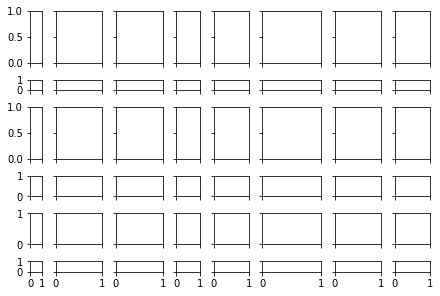

Text(0.5, 0.98, 'Locker Bank Design')

In [48]:
fig6 = plt.figure(constrained_layout=True)

gs_kw = dict(width_ratios=widths, height_ratios=heights)
fig6, f6_axes = plt.subplots(ncols=column, nrows=rowz, sharex='col', sharey='row', constrained_layout=True,
        gridspec_kw=gs_kw)
for r, row in enumerate(f6_axes):
    for c, ax in enumerate(row):
      plt.show()

fig6.suptitle('Locker Bank Design', fontsize=40)  

# Task 4 - Heuristic for Fixed Locker Bank Configuration

To adjust from a dynamic to a fixed design configuration, an upper bound was set and the total dimensions of the design is constrained to equal that bound. 

### *Variables/Parameters*
N<sub>d</sub> = number of lockers of dimesion *d*

L<sub>xy</sub> = location in grid by *x* row and *y* column

D<sub>xy</sub> = dimension of locker measured in grid units

U<sub>xy</sub> = upper bounds of the horizontal and vertical dimensions of the locker bank

A<sub>xy</sub> = assignment of package in to a locker of size *d*

L<sub>d</sub><sub>xy</sub> = implementation of locker of{0,1} at position xy

M<sub>xy</sub> = location of interactive panel

Z<sub>xy</sub> = decision variable if locker is available


#Objective
*Maximize assignment of lockers at single locker bank location for a given scenario*

max $\sum_{d\epsilon D} S$<sub>d</sub> - $\sum_{d\epsilon D} A$<sub>dd</sub> + $\lambda$ ($\sum_{d\epsilon D} N$<sub>d</sub> + $\sum M$<sub>xy</sub> + $\sum D$<sub>xy</sub>) $\forall$$x\epsilon$X, $\forall$$y\epsilon$Y

#Constraints

#### Current Demand Satisfaction
S<sub>d</sub> = $\sum$A $\leq$d<sub>d</sub>

#### Fixes the Dimension of Locker Bank
$\sum $D<sub>xy</sub> = U<sub>xy</sub>

####Total Lockers in Bank Design
N<sub>d</sub> = $\sum$L<sub>d</sub> $\forall$d$\epsilon$D

####Unique Assignment of Item in a Locker
$\sum$A<sub>dd</sub>$ \leq $L<sub>dxy</sub>

####Allocation to Avoid Overlaps in Locker and Interactive Panel Assignment
$\sum$L<sub>dxy</sub>+$\sum$Mxy = Z<sub>xy</sub> $\forall$$x\epsilon$X, $\forall$$y\epsilon$Y

####Prevents gaps or "empty" space in design
Z $\leq$L <sub>xy</sub>/2 

Z$\geq$L <sub>xy</sub> -1

$\forall$$x\epsilon$X, $\forall$$y\epsilon$Y

# Task 4 cont'd and Task 5
####Proposed Design Alternatives and Performance Assessment

##Design Alternative No. 1 - Large


* Scenario 2
* 9th 4-week period
* Demand for Delivery: 900

* Horizontal Upper Bound: 50
* Vertical Upper Bound: 50
* No. of Lockers 1200
* No. of columns 48
* No. of rows 25
* Total Dimensions of Lockers: 7722.0 ft3
* Accept Demand - Enough lockers
* Total Dimensions of Packages: 5819.0 ft3
* Accept Demand - Enough Dimension Space
* Utilization of Locker Bank 75.35612535612536%
* Service Level 75.0 %


##Design Alternative No. 2 - Medium

* Scenario 2
* 9th 4-week period
* Demand for Delivery: 900
* Horizontal Upper Bound: 25
* Vertical Upper Bound: 25
* No. of Lockers 84
* No. of columns 14
* No. of rows 6
* Total Dimensions of Lockers: 573.0 ft3
* Deny Demand - Not Enough Lockers
* Total Dimensions of Packages: 5648.0 
* Deny Demand - Not Enough Dimension Space
* 100% Utilization if Deposited
* Service Level 9.333 %

## Design Alternative No. 3 - Small


* Scenario 3
* 9th 4-week period
* Demand for Delivery: 900
* Horizontal Upper Bound: 10
* Vertical Upper Bound: 10
* No. of Lockers 35
* No. of columns 7
* No. of rows 5
* Total Dimensions of Lockers: 259.0 ft3
* Deny Demand - Not enough lockers
* Total Dimensions of Packages: 5766.0 ft3
* Deny Demand - Not Enough Dimension Space
* 100% Utilization if Deposited
* Service Level 3.888 %

## Design Alternative No. 4 - Large

* Scenario 1
* 12th 4-week period
* Demand for Delivery: 130
* Horizontal Upper Bound: 50
* Vertical Upper Bound: 50
* No. of Lockers 1760
* No. of columns 44
* No. of rows 40
* Total Dimensions of Lockers: 11195.0 ft3
* Accept Demand - Enough lockers
* Total Dimensions of Packages: 812.0 ft3
* Accept Demand - Enough Dimension Space
* Utilization of Locker Bank 7.253%
* Service Level 100%


## Design Alternative No. 5 - Medium

* Scenario 1
* 12th 4-week period
* Demand for Delivery: 130
* Horizontal Upper Bound: 25
* Vertical Upper Bound: 25
* No. of Lockers 182
* No. of columns 14
* No. of rows 13
* Total Dimensions of Lockers: 1206.0 ft3
* Accept Demand - Enough lockers
* Total Dimensions of Packages: 897.0 ft3
* Accept Demand - Enough Dimension Space
* Utilization of Locker Bank 74.378 %
* Daily Service Level 71.428* %